# Ежедневные метрики

AvP - средний чек за день
<br>ARPU - средняя доходность с одного пользователя. Проверяем "сходится" у нас экономика или нет.
<br>UA - количество привлеченных пользователей
<br>C1 - конверсия пользователей в покупателей

# Анализ данных

Инсайты:
- разницы в среднем чеке у людей с промокодом на доставку и без нет
- 25% пользователей делают повторный заказ
- промо код стимулирует покупать. Так больше людей совершили первую покупку с промокодом. Также среди людей сделавших повторный заказ больше тех кто пользовался промокодами. Очевидно, что с помощью этого инструмента можно повысить конверсию во вторую покупку.
- У пользователей без промокода на доставку, стоимость доставки составляет в среднем 6.6%, с промокодом стоимость снимажется до 2% от чека. На основе этих данных, зная наши затраты на логистику и доставку, можно высчитать минимальное количество промокодов, которое компенсирует наши потери на доставке.
- В абсолютных числах количество отмененых или заменённых позиций максимально у сети №1. Такое получется лишь из-за того, что сеть №1 лидер по количеству заказов. Если смотреть в процентном соотношениий, то другие сети показывают себя намного хуже. Поэтому масштабирование доставок из этих сетей приведет к большему количеству отказов и замен. Мы можем поделиться с ретейлером статистикой проблемных позиций, чтобы стимулировать увеличивать закупку этих позиций. 
- По скорости сбора заказа и его отправки лидирует сеть №16. Скорее всего это связано с небольшим количеством заказов. В остальных заказ до отправки ждет 20 часов.
- Заказ чаще всего отправляется из магазина под конец слота доставки. То есть время не соблюдается. 

## Импорт данных

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
con = psycopg2.connect(
    host='rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net',
    port=6432,
    dbname='hr-analytics',
    sslmode='require',
    user='analytics',
    password='HRanalytics'
) 
cur = con.cursor()

In [3]:
def select(sql):
  return pd.read_sql(sql,con)

In [4]:
orders = pd.read_sql('''select * from orders''',con)

## Влияние промо-кода на доставку на средний чек

Оценим влияет ли наличие промокода на доставку на средний чек и на желание сделать заказ.

In [5]:
orders.item_total.describe()

count    334245.000000
mean       4917.515152
std        5526.465519
min           0.000000
25%        2566.000000
50%        3873.000000
75%        5806.000000
max      480746.000000
Name: item_total, dtype: float64

In [6]:
temp1 = orders.query('item_total < 10000')
temp1 = temp1.assign(promo = temp1.apply(lambda x: 0 if x.total_cost == x.cost else 1, axis=1 ))

In [7]:
temp1 = temp1.assign(total = temp1.total_cost + temp1.item_total + temp1.promo_total)

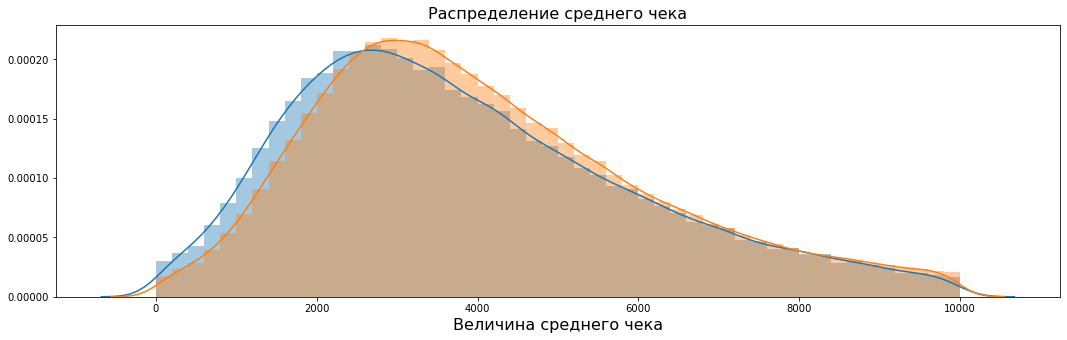

In [8]:
plt.figure(figsize=(18, 5))
sns.distplot(temp1.query('promo == 1 and state == "shipped"').item_total)
ax = sns.distplot(temp1.query('promo == 0 and state == "shipped"').item_total)
ax.set_xlabel('Величина среднего чека', fontdict={'fontsize': 16})
ax.set_title('Распределение среднего чека', fontdict={'fontsize': 16});

Видно, что наличие промокода не сильно влияет на средний чек покупки, но влияет на количество заказов. Теперь нам нужно оценить смогли ли мы заработать на большем количестве заказов или нет.

In [9]:
temp2 = temp1.pivot_table(index='user_id', values='promo', aggfunc=['count', 'sum']).reset_index()

In [10]:
temp2.columns = ['user_id', 'count', 'sum']
temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114903 entries, 0 to 114902
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  114903 non-null  int64
 1   count    114903 non-null  int64
 2   sum      114903 non-null  int64
dtypes: int64(3)
memory usage: 2.6 MB


In [11]:
temp2['count'].describe()

count    114903.000000
mean          2.705891
std           5.742368
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         473.000000
Name: count, dtype: float64

Только 25% пользовоталей приходят к нам повторно. Изучим как на это повлияли промо коды на покупку.

In [12]:
temp2 = temp2.query('count < 2')

In [13]:
delta = temp2['count'] - temp2['sum']

In [14]:
delta.value_counts()

0    43246
1    30276
dtype: int64

43246 сделали первую покупку с помощью промокода, 30276 без него.

In [15]:
temp1.query('promo == 1')['total_cost'].describe()

count    94189.000000
mean        63.507320
std         93.142647
min       -298.000000
25%          0.000000
50%          0.000000
75%        158.000000
max       2374.000000
Name: total_cost, dtype: float64

Половина доставки с промокодом бесплатная.

In [16]:
temp1.query('promo == 0')['total_cost'].describe()

count    216726.000000
mean        231.537276
std         144.438421
min           0.000000
25%         149.000000
50%         298.000000
75%         299.000000
max        4279.000000
Name: total_cost, dtype: float64

Медиана цены доставки составляет 298 рублей.

In [17]:
temp2 = temp1.query('promo == 0')
np.mean(temp2.total_cost / temp2.total)

0.0667600433854935

Около 6.6% от чека составляют затраты на доставку у пользователей без промокода.

In [18]:
temp2 = temp1.query('promo == 1')
np.mean(temp2.total_cost / temp2.total)

0.02010160086713397

Пользователи с промокодом платят в среднем всего 2% за доставку. 

В целом чтобы увеличить конверсию во вторую покупку можно пользователем, совершившим первую покупку предоставлять промо код на бесплатную достаку.

In [19]:
temp2 = temp1.pivot_table(index='user_id', values='promo', aggfunc=['count', 'sum']).reset_index()
temp2.columns = ['user_id', 'count', 'sum']
temp2.query('count == 2')

,user_id,count,sum
8,194,2,0
16,479,2,1
20,509,2,1
22,562,2,0
32,668,2,0
...,...,...,...
114550,672695,2,0
114642,673984,2,1
114710,675192,2,1
114758,676501,2,2


In [20]:
temp2.query('count == 2')['sum'].value_counts()

1    7743
0    6433
2    2166
Name: sum, dtype: int64

Наличие хотя бы одного промокода на доставку увеличивает количество повторных пользователей.

## Сеть с наибольшим количеством отказов и замен

In [21]:
sql = '''
select orders.id as order, orders.total_quantity, stores.*, q.count as cancel_cnt, t.count as replace_cnt
from orders
join stores on orders.store_id = stores.id
join (select order_id, count(item_id) from cancellations
    group by order_id) q on orders.id = q.order_id
join (select order_id, count(item_id) from replacements
    group by order_id) t on orders.id = t.order_id
'''

In [22]:
temp = select(sql)
temp

,order,total_quantity,id,city,retailer_id,cancel_cnt,replace_cnt
0,557,13,14,1,1,5,1
1,4123,42,1,1,1,3,1
2,142598,45,1,1,1,1,7
3,152001,48,8,1,1,2,5
4,165970,142,12,1,1,1,2
...,...,...,...,...,...,...,...
97219,5509342,10,70,1,15,1,1
97220,5509777,32,14,1,1,7,3
97221,5509851,33,8,1,1,1,2
97222,5509951,19,14,1,1,1,1


In [23]:
temp.pivot_table(index='city', aggfunc='sum', values=['cancel_cnt', 'replace_cnt']).reset_index()

,city,cancel_cnt,replace_cnt
0,1,218807,202920
1,2,13410,14954
2,5,4443,3786
3,8,3220,2397
4,10,6461,4281
5,13,2735,2738
6,20,2334,2085
7,23,1157,1028


Больше всего отмен и замен в городе 1, что связано и с самым большим количеством заказов.

In [24]:
temp3 = temp.pivot_table(index='retailer_id', aggfunc={'cancel_cnt' : 'sum',
                                              'replace_cnt' : 'sum',
                                              'order' : 'count',
                                              'total_quantity' : 'sum'}).reset_index()

In [25]:
temp3 = temp3.assign(cancel_proc = temp3.cancel_cnt / temp3.total_quantity * 100,
            replace_proc = temp3.replace_cnt / temp3.total_quantity * 100)

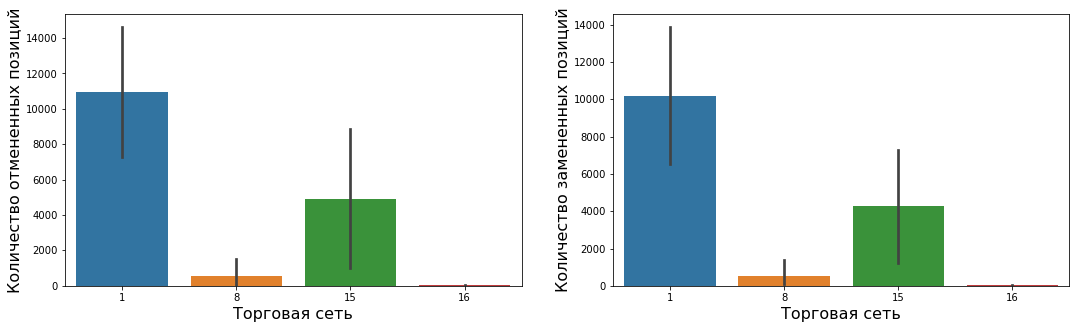

In [26]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
ax1 = sns.barplot(
    data=temp.pivot_table(index=['retailer_id', 'id'], aggfunc='sum', values=['cancel_cnt', 'replace_cnt']).reset_index(), 
    x="retailer_id", y="cancel_cnt")
ax1.set_xlabel('Торговая сеть', fontdict={'fontsize': 16})
ax1.set_ylabel('Количество отмененных позиций', fontdict={'fontsize': 16})
ax2 = plt.subplot(122)
ax2 = sns.barplot(
    data=temp.pivot_table(index=['retailer_id', 'id'], aggfunc='sum', values=['cancel_cnt', 'replace_cnt']).reset_index(), 
    x="retailer_id", y="replace_cnt")
ax2.set_xlabel('Торговая сеть', fontdict={'fontsize': 16})
ax2.set_ylabel('Количество замененных позиций', fontdict={'fontsize': 16});

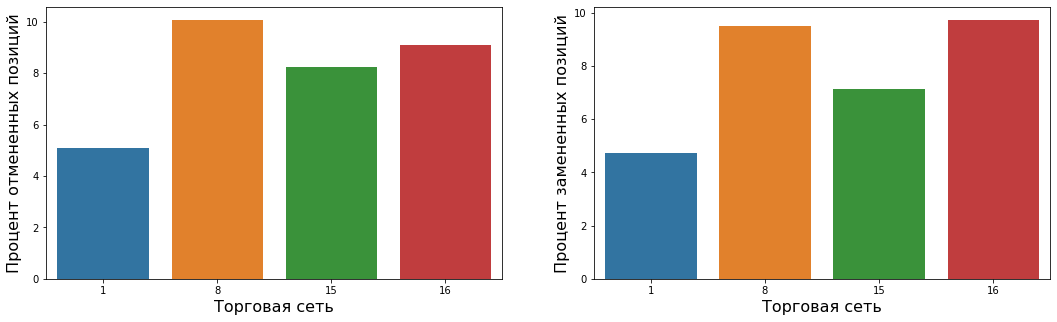

In [27]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
ax1 = sns.barplot(data=temp3, 
    x="retailer_id", y="cancel_proc")
ax1.set_xlabel('Торговая сеть', fontdict={'fontsize': 16})
ax1.set_ylabel('Процент отмененных позиций', fontdict={'fontsize': 16})
ax2 = plt.subplot(122)
ax2 = sns.barplot(data=temp3, 
    x="retailer_id", y="replace_proc")
ax2.set_xlabel('Торговая сеть', fontdict={'fontsize': 16})
ax2.set_ylabel('Процент замененных позиций', fontdict={'fontsize': 16});

По абсолютному значению отмен и замен лидирует сеть №1. Но эта сеть имеет также подавляющее большинство заказов. Если смотреть на сети 8, 15 и 16, то увелечение заказов оттуда понесет больший процент замен и отмен. Поэтому необходимо дать статистику по недостающим позициям в сеть №1 с целью корректировки заказов.

### Cредний чек и количество заказов во времени

In [28]:
temp1 = temp1.assign(day = temp1.created_at.astype('datetime64[M]'))
temp6 = (temp1
         .pivot_table(index='day', aggfunc={'item_total' : 'mean', 'id' : 'count'})
         .reset_index()
         .query('day != "2019-08-01"'))

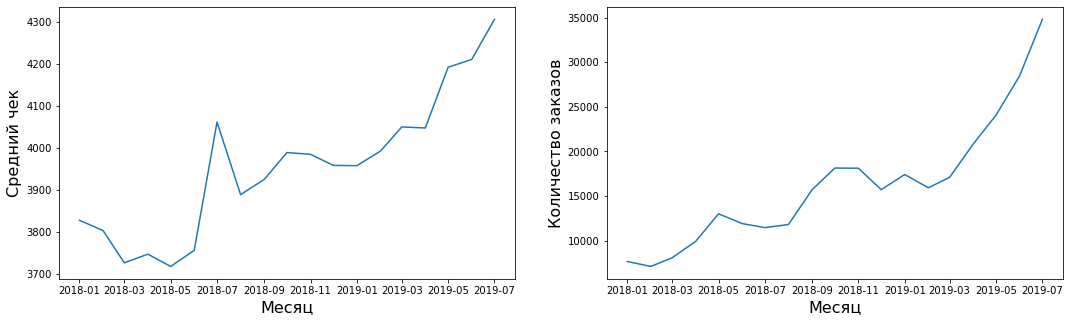

In [29]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
ax1 = sns.lineplot(data=temp6,
             x='day', y='item_total')
ax1.set_xlabel('Месяц', fontdict={'fontsize': 16})
ax1.set_ylabel('Средний чек', fontdict={'fontsize': 16})
ax2 = plt.subplot(122)
ax2 = sns.lineplot(data=temp6,
             x='day', y='id')
ax2.set_xlabel('Месяц', fontdict={'fontsize': 16})
ax2.set_ylabel('Количество заказов', fontdict={'fontsize': 16});

Средний чек и количество пользователей растет. Бизнес растет.

### Зависимость времени доставки от веса

In [30]:
temp1 = temp1.assign(t_delta = (temp1.shipped_at - temp1.created_at).apply(lambda x: x.total_seconds() / 3600))
temp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310915 entries, 0 to 334243
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  310915 non-null  int64         
 1   user_id             310915 non-null  int64         
 2   total_cost          310915 non-null  float64       
 3   cost                310915 non-null  float64       
 4   item_total          310915 non-null  int64         
 5   promo_total         310915 non-null  float64       
 6   total_weight        310915 non-null  int64         
 7   total_quantity      310915 non-null  int64         
 8   state               310915 non-null  object        
 9   shipped_at          310915 non-null  datetime64[ns]
 10  created_at          310915 non-null  datetime64[ns]
 11  ship_address_id     310915 non-null  int64         
 12  store_id            310915 non-null  int64         
 13  delivery_window_id  310914 no

In [31]:
temp1[['total_cost', 'item_total', 'total_weight', 'total_quantity', 't_delta']].corr()

,total_cost,item_total,total_weight,total_quantity,t_delta
total_cost,1.000000,0.166924,0.271597,0.145380,0.028448
item_total,0.166924,1.000000,0.325326,0.373721,0.015148
total_weight,0.271597,0.325326,1.000000,0.365512,0.011055
total_quantity,0.145380,0.373721,0.365512,1.000000,0.006391
t_delta,0.028448,0.015148,0.011055,0.006391,1.000000


Сильной корреляции между параметрами не наблюдается.

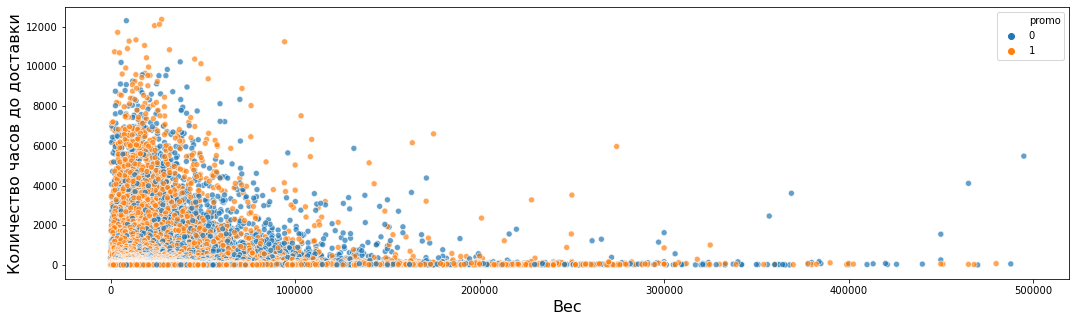

In [32]:
plt.figure(figsize=(18, 5))
ax = sns.scatterplot(data=temp1.query('total_weight < 500000'), x='total_weight', y='t_delta', hue='promo', alpha=0.7)
ax.set_xlabel('Вес', fontdict={'fontsize': 16})
ax.set_ylabel('Количество часов до доставки', fontdict={'fontsize': 16});

Разницы между временем между соданием заказа и отправкой не зависит от наличия промо-кода на доставку.

In [33]:
temp1.query('promo == 0').t_delta.describe()

count    216726.000000
mean         98.264571
std         365.975472
min           0.003056
25%           9.737292
50%          21.554722
75%          46.147986
max       12292.800833
Name: t_delta, dtype: float64

In [34]:
temp1.query('promo == 1').t_delta.describe()

count    94189.000000
mean       105.950718
std        485.311561
min        -71.959722
25%          9.030833
50%         20.726389
75%         40.701111
max      12361.520000
Name: t_delta, dtype: float64

### Как магазин влияет на время доставки

In [35]:
sql = '''
select 
DATE_PART('day', orders.shipped_at::timestamp - orders.created_at::timestamp) * 24 + 
DATE_PART('hour', orders.shipped_at::timestamp - orders.created_at::timestamp) as creat_ship_del,
DATE_PART('day', delivery_windows.ends_at::timestamp - orders.shipped_at::timestamp) * 24 + 
DATE_PART('hour', delivery_windows.ends_at::timestamp - orders.shipped_at::timestamp) as ship_winend_del,
orders.created_at, 
orders.shipped_at, 
delivery_windows.starts_at, 
delivery_windows.ends_at, 
stores.id,
stores.retailer_id
from orders
join delivery_windows on orders.delivery_window_id = delivery_windows.id
join stores on orders.store_id = stores.id

'''
temp7 = select(sql)

In [36]:
temp7.pivot_table(index='retailer_id', values=['creat_ship_del', 'ship_winend_del'], aggfunc='median')

,creat_ship_del,ship_winend_del
retailer_id,,
1,21.0,0.0
8,20.0,0.0
15,14.0,1.0
16,3.0,0.0


Среднее время зависят от количества заказов. Сети 1 и 8 наиболее загруженные. Обнаружилась проблема с доставкой продуктов в срок. Практически в каждой сети средняя разница во времени между отправкой заказа и закрытием временного окна меньше часа.